In [39]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd


In [40]:
# Instrument / geometry constants (SI units)
nprim = 400
nsec = 500
Lprim = 0.042  # m
Lprim_error = 0.001  # m (unused but kept for record)
Ri = 32680
Ri_error = 10
C_val = 97.8e-9
C_val_error = 0.1e-9
R_prim = 2
mu_0 = 4e-7 * np.pi

# Cross-sectional areas (mm^2)
material_area_mm2 = {
    "transformer_iron": 2.4,
    "mild_steel": 7.65,
    "copper_alloy": 19.6,
}

# Optional measurement uncertainties (unused but preserved)
material_area_error_mm2 = {
    "transformer_iron": 0.016,
    "mild_steel": 0.02,
    "copper_alloy": 0.16,
}

BASE_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
DATA_ROOT = BASE_DIR.parent / "data" / "hysteresis data"
PLOT_ROOT = BASE_DIR / "hysteresis_plots"
LOOP_DURATION_S = 0.02  # seconds of data (20 ms) per loop


In [41]:
def H_calc(v_primary: np.ndarray) -> np.ndarray:
    """Convert measured primary voltage to magnetising field H (A/m)."""
    return v_primary * (nprim / (Lprim * R_prim))


def B_calc(v_secondary: np.ndarray, material: str) -> np.ndarray:
    """Convert measured secondary voltage to flux density B (T)."""
    area_m2 = material_area_mm2[material] * 1e-6  # mm² → m²
    #gain = 1.37 # integrator gain from experimental calibration
    gain = 1.37
    return (v_secondary / (area_m2 * gain * nsec))


def infer_material_from_path(csv_path: Path) -> str:
    """Infer material key from any part of the dataset path or filename."""
    lowered = str(csv_path).lower()
    for key in material_area_mm2:
        if key in lowered:
            return key
    raise ValueError(
        f"Unable to infer material for '{csv_path}'. "
        f"Expected one of {list(material_area_mm2)} to appear in the path or filename."
    )


def load_capture(csv_path: Path) -> pd.DataFrame:
    """Load a single hysteresis capture, normalising Channel A/B to volts."""
    units_map: Dict[str, str] = {}
    with csv_path.open("r", encoding="utf-8") as fh:
        headers = fh.readline().strip().split(",")
        unit_line = fh.readline().strip().split(",")
        for name, unit in zip(headers, unit_line):
            unit_clean = unit.strip().strip("()").lower()
            units_map[name.strip()] = unit_clean

    df = pd.read_csv(csv_path, skiprows=[1])
    df = df.dropna(subset=["Channel A", "Channel B"])
    df = df.astype(float)

    # Ensure Channel A/B are in volts regardless of original units.
    scale_map = {
        "v": 1.0,
        "mv": 1e-3,
        "uv": 1e-6,
        "kv": 1e3,
    }
    for col in ("Channel A", "Channel B"):
        unit = units_map.get(col, "").lower()
        factor = scale_map.get(unit, 1.0)
        df[col] *= factor

    time_col = df.columns[0]
    df = df.rename(columns={time_col: "Time_ms"})
    df = df.sort_values("Time_ms").reset_index(drop=True)
    return df


def extract_loop_window(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract a 0.02 s window (20 ms) centred on the time closest to zero.

    Falls back to the entire capture if the dataset is shorter than the window.
    """
    time_ms = df["Time_ms"].to_numpy()
    if len(time_ms) == 0:
        return df

    center_idx = int(np.argmin(np.abs(time_ms)))
    center_time = time_ms[center_idx]
    half_window = (LOOP_DURATION_S * 1000) / 2.0  # convert to ms
    lower = center_time - half_window
    upper = center_time + half_window
    mask = (time_ms >= lower) & (time_ms <= upper)
    if not np.any(mask):
        return df
    return df.loc[mask].reset_index(drop=True)


def csv_path_to_var_name(csv_path: Path) -> str:
    """Create a Python-safe variable name from the CSV stem."""
    stem = csv_path.stem.lower()
    safe = ["capture"]
    for ch in stem:
        safe.append(ch if ch.isalnum() else "_")
    name = "".join(safe)
    while "__" in name:
        name = name.replace("__", "_")
    return name.strip("_")


def dataframe_to_triplet(df: pd.DataFrame) -> np.ndarray:
    """Return stacked numpy array [time_ms, channel_a_v, channel_b_v]."""
    return np.vstack(
        (
            df["Time_ms"].to_numpy(),
            df["Channel A"].to_numpy(),
            df["Channel B"].to_numpy(),
        )
    )


def build_capture_arrays(data_root: Path) -> Dict[str, np.ndarray]:
    """
    Load every CSV in data_root into a 3xN array ordered as (time, channel A, channel B).
    Returns a dictionary keyed by safe variable names derived from the filenames.
    """
    arrays: Dict[str, np.ndarray] = {}
    for csv_path in sorted(Path(data_root).glob("*.csv")):
        df = load_capture(csv_path)
        arrays[csv_path_to_var_name(csv_path)] = dataframe_to_triplet(df)
    return arrays


def build_capture_stack(arrays: Dict[str, np.ndarray]) -> np.ndarray:
    """
    Stack individual 3xN capture arrays into shape (num_files, 3, N).
    Assumes all captures are the same length.
    """
    lengths = {name: arr.shape[1] for name, arr in arrays.items()}
    if len(set(lengths.values())) != 1:
        raise ValueError(
            "Capture lengths differ; cannot stack into a single 3D array: " + str(lengths)
        )
    return np.stack(list(arrays.values()))

def split_hysteresis_loops(d3_arr):
    # Copy the original data so we never modify d3_arr in-place
    time = np.array(d3_arr[0]).copy()
    a    = np.array(d3_arr[1]).copy()
    b    = np.array(d3_arr[2]).copy()

    loops = []
    n = len(time)
    start = 0
    counter = 0

    # Build up to 20 loops
    while start < n and counter < 20:
        init_time = time[start]

        # Find the first index where time > init_time + 20
        end = start
        while end < n and time[end] <= init_time + 20:
            end += 1

        # If we never find a point beyond init_time + 20,
        # there isn't a full new loop to add – stop here.
        if end == n:
            break

        # Add this loop (time, a, b over this interval)
        loops.append([
            time[start:end],
            a[start:end],
            b[start:end],
        ])

        # Next loop starts where this one ended
        start = end
        counter += 1

    return loops # [[time],[a],[b]]

def build_loop(loops,material): #[[time],[a],[b]]
    time = loops[0]
    a = loops[1]
    b = loops[2]

    H = H_calc(a)
    B = B_calc(b, material)

    return H, B

'''
def poly_reg_loop(loop, lowerH: float = -np.inf, upperH: float = np.inf):
    H = loop[0]
    B = loop[1]
    degree = 5

    #split the curve int 4 sections and fit each with polyfit


    mask_lower = H <= lowerH
    mask_upper = H >= upperH

    h_lin_1 = H[mask_lower]
    b_lin_1 = B[mask_lower]

    h_lin_2 = H[mask_upper]
    b_lin_2 = B[mask_upper]



    # Fit polynomials of given degree
    coeffs_lower = np.polyfit(h_lin_1, b_lin_1, degree)
    coeffs_upper = np.polyfit(h_lin_2, b_lin_2, degree)
    def top_section(H_inp, B_inp):
        lower_point = [lowerH, np.polyval(coeffs_lower, lowerH)]
        upper_point = [upperH, np.polyval(coeffs_upper, upperH)]
        grad = (upper_point[1] - lower_point[1]) / (upper_point[0] - lower_point[0])
        intercept = lower_point[1] - grad * lower_point[0]
        return grad * H_inp + intercept < B_inp
    
    upper_mid_h = H[top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    upper_mid_b = B[top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    lower_mid_h = H[~top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    lower_mid_b = B[~top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    coeffs_mid_upper = np.polyfit(upper_mid_h, upper_mid_b, degree)
    coeffs_mid_lower = np.polyfit(lower_mid_h, lower_mid_b, degree)

    # Start from original B and overwrite fitted regions
    B_new = B.copy()
    B_new[mask_lower] = np.polyval(coeffs_lower, H[mask_lower])
    B_new[mask_upper] = np.polyval(coeffs_upper, H[mask_upper])
    B_new[(H >= lowerH) & (H <= upperH) & top_section(H, B)] = np.polyval(coeffs_mid_upper, H[(H >= lowerH) & (H <= upperH) & top_section(H, B)])
    B_new[(H >= lowerH) & (H <= upperH) & ~top_section(H, B)] = np.polyval(coeffs_mid_lower, H[(H >= lowerH) & (H <= upperH) & ~top_section(H, B)])
    error = abs(B - B_new)

    def polyfit_grad_bounds():
        """Return (min_abs_grad, max_abs_grad) across the fitted piecewise polynomials."""
        grads = []
        if np.any(mask_lower):
            grads.extend(np.polyval(np.polyder(coeffs_lower), H[mask_lower]))
        mid_upper_mask = (H >= lowerH) & (H <= upperH) & top_section(H, B)
        if np.any(mid_upper_mask):
            grads.extend(np.polyval(np.polyder(coeffs_mid_upper), H[mid_upper_mask]))
        mid_lower_mask = (H >= lowerH) & (H <= upperH) & ~top_section(H, B)
        if np.any(mid_lower_mask):
            grads.extend(np.polyval(np.polyder(coeffs_mid_lower), H[mid_lower_mask]))
        if np.any(mask_upper):
            grads.extend(np.polyval(np.polyder(coeffs_upper), H[mask_upper]))
        if not grads:
            return float("nan"), float("nan")
        grads_abs = np.abs(grads)
        return float(np.min(grads_abs)), float(np.max(grads_abs))

    min_poly_grad, max_poly_grad = polyfit_grad_bounds()
    
    #ignore the points where my polyfits join +/- 5%
    mask = (H < lowerH*1.05) | (H > upperH*0.95)
    H_calc = H[mask]
    B_calc = B_new[mask]
    #split loop from ends
    H_upper = H_calc[H_calc >= upperH]
    B_upper = B_calc[H_calc >= upperH]
    H_lower = H_calc[H_calc <= lowerH]
    B_lower = B_calc[H_calc <= lowerH]
    H_mid = H_calc[(H_calc > lowerH) & (H_calc < upperH)]
    B_mid = B_calc[(H_calc > lowerH) & (H_calc < upperH)]

    #graph_calc(H, B, error):
    H_range = max(H_calc) - min(H_calc)
    B_range = max(B_calc) - min(B_calc)
    loop_area = np.trapz(B_calc, H_calc)
    max_grad = max(abs(np.gradient(B_calc, H_calc)))
    min_grad = min(abs(np.gradient(B_calc, H_calc)))
    calc = {
        "H_range": H_range,
        "B_range": B_range,
        "loop_area": loop_area,
        "max_mu_r": max_grad,
        "min_mu_r": min_grad,
        "polyfit_grad_min": min_poly_grad,
        "polyfit_grad_max": max_poly_grad
    }

    

    return H, B_new, error, calc
'''
import numpy as np

def smooth_segment(y, window_frac: float = 0.05, min_window: int = 11):
    """
    Simple moving-average smoother.
    Window ≈ window_frac * len(y), clamped between min_window and len(y),
    and forced to be odd.
    """
    y = np.asarray(y, dtype=float)
    n = y.size
    if n < 3:
        return y.copy()

    w = max(min_window, int(n * window_frac))
    if w % 2 == 0:
        w += 1
    if w > n:
        w = n if n % 2 == 1 else n - 1
    if w < 3:
        return y.copy()

    kernel = np.ones(w, dtype=float) / w
    y_padded = np.pad(y, (w // 2,), mode="edge")
    return np.convolve(y_padded, kernel, mode="valid")


def poly_reg_loop(loop, lowerH: float = -np.inf, upperH: float = np.inf):
    H = np.asarray(loop[0])
    B = np.asarray(loop[1])
    degree = 5

    # --- Split into end (polyfit) and middle (smooth) regions ---
    mask_lower = H <= lowerH
    mask_upper = H >= upperH
    mask_mid   = (H > lowerH) & (H < upperH)

    h_lin_1 = H[mask_lower]
    b_lin_1 = B[mask_lower]
    h_lin_2 = H[mask_upper]
    b_lin_2 = B[mask_upper]

    coeffs_lower = np.polyfit(h_lin_1, b_lin_1,
                              min(degree, len(h_lin_1) - 1)) if len(h_lin_1) > 1 else None
    coeffs_upper = np.polyfit(h_lin_2, b_lin_2,
                              min(degree, len(h_lin_2) - 1)) if len(h_lin_2) > 1 else None

    # --- Define upper vs lower half of the loop using a divider line ---
    def top_section(H_inp, B_inp):
        # If we can't define the divider, just say "no top section"
        if coeffs_lower is None or coeffs_upper is None:
            return np.zeros_like(B_inp, dtype=bool)

        lower_point = [lowerH, np.polyval(coeffs_lower, lowerH)]
        upper_point = [upperH, np.polyval(coeffs_upper, upperH)]
        grad = (upper_point[1] - lower_point[1]) / (upper_point[0] - lower_point[0])
        intercept = lower_point[1] - grad * lower_point[0]

        # True = above the divider line (top half of loop)
        return grad * H_inp + intercept < B_inp

    mid_top_mask = mask_mid & top_section(H, B)      # upper half in middle region
    mid_bot_mask = mask_mid & ~top_section(H, B)     # lower half in middle region

    # --- Build B_new: polyfit on ends, smooth middle parts by branch & by block ---
    B_new = B.copy()

    # Polyfit the ends
    if coeffs_lower is not None and np.any(mask_lower):
        B_new[mask_lower] = np.polyval(coeffs_lower, H[mask_lower])
    if coeffs_upper is not None and np.any(mask_upper):
        B_new[mask_upper] = np.polyval(coeffs_upper, H[mask_upper])

    def smooth_by_blocks(mask):
        """
        Apply smoothing separately to each contiguous block of indices
        where 'mask' is True. This avoids smoothing across the vertical jumps.
        """
        idx = np.where(mask)[0]
        if idx.size == 0:
            return

        # Find breaks in the mask (where indices jump by > 1)
        splits = np.where(np.diff(idx) > 1)[0] + 1
        blocks = np.split(idx, splits)

        for block in blocks:
            if block.size < 3:
                continue
            B_new[block] = smooth_segment(B[block])

    # Smooth upper and lower halves of the middle **separately**
    smooth_by_blocks(mid_top_mask)
    smooth_by_blocks(mid_bot_mask)

    # --- Error between original and processed loop ---
    error = np.abs(B - B_new)

    # --- For reporting polyfit gradient bounds, fit polynomials to the smoothed mids ---
    coeffs_mid_upper = None
    coeffs_mid_lower = None
    if np.any(mid_top_mask) and np.sum(mid_top_mask) > 1:
        upper_mid_h = H[mid_top_mask]
        upper_mid_b = B_new[mid_top_mask]
        coeffs_mid_upper = np.polyfit(upper_mid_h, upper_mid_b,
                                      min(degree, len(upper_mid_h) - 1))
    if np.any(mid_bot_mask) and np.sum(mid_bot_mask) > 1:
        lower_mid_h = H[mid_bot_mask]
        lower_mid_b = B_new[mid_bot_mask]
        coeffs_mid_lower = np.polyfit(lower_mid_h, lower_mid_b,
                                      min(degree, len(lower_mid_h) - 1))

    def polyfit_grad_bounds():
        grads = []

        if coeffs_lower is not None and np.any(mask_lower):
            grads.extend(np.polyval(np.polyder(coeffs_lower), H[mask_lower]).tolist())
        if coeffs_mid_upper is not None and np.any(mid_top_mask):
            grads.extend(np.polyval(np.polyder(coeffs_mid_upper), H[mid_top_mask]).tolist())
        if coeffs_mid_lower is not None and np.any(mid_bot_mask):
            grads.extend(np.polyval(np.polyder(coeffs_mid_lower), H[mid_bot_mask]).tolist())
        if coeffs_upper is not None and np.any(mask_upper):
            grads.extend(np.polyval(np.polyder(coeffs_upper), H[mask_upper]).tolist())

        if not grads:
            return float("nan"), float("nan")

        grads_abs = np.abs(np.asarray(grads))
        return float(np.min(grads_abs)), float(np.max(grads_abs))

    min_poly_grad, max_poly_grad = polyfit_grad_bounds()

    # --- Numeric gradient for μ_r, excluding join regions (±5%) ---
    mask_calc = (H < lowerH * 1.05) | (H > upperH * 0.95)
    H_calc = H[mask_calc]
    B_calc = B_new[mask_calc]

    dH = np.diff(H_calc)
    dB = np.diff(B_calc)
    valid = np.isfinite(dH) & (dH != 0) & np.isfinite(dB)

    if np.any(valid):
        mu_vals = np.abs(dB[valid] / dH[valid])
        max_grad = float(np.max(mu_vals))
        min_grad = float(np.min(mu_vals))
    else:
        max_grad = float("nan")
        min_grad = float("nan")

    # --- Loop geometry and summary ---
    H_range = float(np.max(H_calc) - np.min(H_calc))
    B_range = float(np.max(B_calc) - np.min(B_calc))

    H_range = float(np.max(H_calc) - np.min(H_calc))
    B_range = float(np.max(B_calc) - np.min(B_calc))

    # --- loop area only between the polynomial tails ---
    mid_mask = (H >= lowerH) & (H <= upperH)
    H_mid = H[mid_mask]
    B_mid = B_new[mid_mask]

    # split into left (H <= 0) and right (H >= 0) of the y-axis
    left_mask = H_mid <= 0
    right_mask = H_mid >= 0

    # guard against edge cases with too few points
    if np.count_nonzero(left_mask) > 1:
        area_left = np.trapz(B_mid[left_mask], H_mid[left_mask])
    else:
        area_left = 0.0

    if np.count_nonzero(right_mask) > 1:
        area_right = np.trapz(B_mid[right_mask], H_mid[right_mask])
    else:
        area_right = 0.0

    # sum of absolute areas of left and right halves
    loop_area = float(abs(area_left) + abs(area_right))


    calc = {
        "H_range": H_range,
        "B_range": B_range,
        "loop_area": loop_area,
        "max_mu_r": max_grad/mu_0,           # from numeric gradient of smoothed loop
        "min_mu_r": min_grad/mu_0,
        "polyfit_grad_min": min_poly_grad,
        "polyfit_grad_max": max_poly_grad,
    }

    return H, B_new, error, calc


In [42]:
# Build 3D numpy arrays for each capture: (time_ms, Channel A [V], Channel B [V])
DATA_ROOT = Path(DATA_ROOT)
capture_arrays: Dict[str, np.ndarray] = build_capture_arrays(DATA_ROOT)
capture_names = list(capture_arrays.keys())
captures_3d = build_capture_stack(capture_arrays)
capture_dic = {}

# Expose individual variables for quick access in the notebook workspace.
globals().update(capture_arrays)

print(f"Loaded {len(capture_arrays)} captures from {DATA_ROOT}")
for name, arr in capture_arrays.items():
    print(f'{name}: shape {arr.shape}')
    capture_dic[name] = arr
print(f'Combined stack shape: {captures_3d.shape}')


Loaded 6 captures from /home/shani/physics report michaelmas/data/hysteresis data
capture6_3_2_copper_alloy_above_40_c: shape (3, 976567)
capture6_3_2_copper_alloy_above_40_c_3: shape (3, 976567)
capture6_3_2copper_alloy_at_10_c: shape (3, 976567)
capture6_3_2mild_steel: shape (3, 976567)
capture6_3_2transformer_iron: shape (3, 976567)
capture6_3_2transformer_iron_set2: shape (3, 976567)
Combined stack shape: (6, 3, 976567)


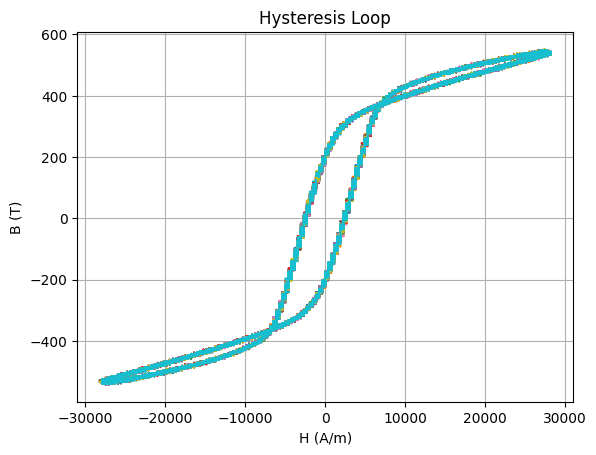

/tmp/ipykernel_44463/1272145208.py:437: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_left = np.trapz(B_mid[left_mask], H_mid[left_mask])
/tmp/ipykernel_44463/1272145208.py:442: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_right = np.trapz(B_mid[right_mask], H_mid[right_mask])


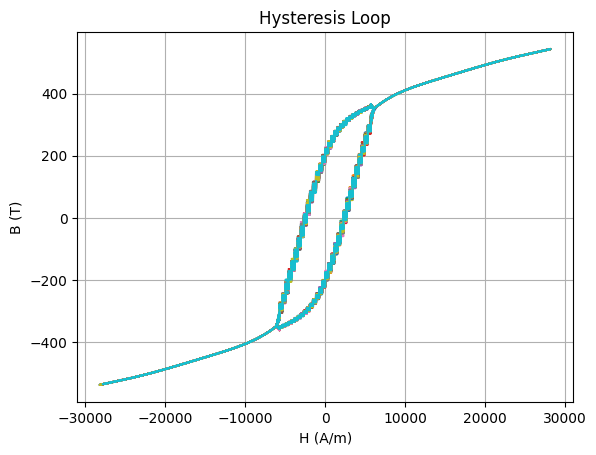

In [43]:
for i in range(20):
    sman = build_loop(split_hysteresis_loops(captures_3d[4])[i], "transformer_iron")
    plt.plot(sman[0],sman[1])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Hysteresis Loop")
plt.grid()
plt.show()

'''for i in range(20):
    sman = lin_reg_loop(-7000, 7000, build_loop(split_hysteresis_loops(captures_3d[4])[i], "transformer_iron"))
    plt.plot(sman[0],sman[1])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Hysteresis Loop")
plt.grid()
plt.show()'''

for i in range(20):
    sman = poly_reg_loop(build_loop(split_hysteresis_loops(captures_3d[4])[i], "transformer_iron"),-6000, 6000)
    plt.plot(sman[0],sman[1])
    #plt.errorbar(sman[0], sman[1], yerr=sman[2], fmt='o', markersize=2, alpha=0.3)
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Hysteresis Loop")
plt.grid()
plt.show()


In [44]:
poly_reg_loop(build_loop(split_hysteresis_loops(capture_dic['capture6_3_2transformer_iron'])[0], "transformer_iron"),-6000, 6000)


/tmp/ipykernel_44463/1272145208.py:437: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_left = np.trapz(B_mid[left_mask], H_mid[left_mask])
/tmp/ipykernel_44463/1272145208.py:442: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_right = np.trapz(B_mid[right_mask], H_mid[right_mask])


(array([-4953.48095238, -4953.48095238, -4953.48095238, ...,
        -4572.67095238, -4572.67095238, -4572.67095238], shape=(39063,)),
 array([-240.39409976, -240.39409976, -240.39409976, ..., -210.63785749,
        -210.77523601, -210.91261453], shape=(39063,)),
 array([5.68434189e-14, 5.68434189e-14, 5.68434189e-14, ...,
        5.71494056e+00, 5.57756204e+00, 5.44018352e+00], shape=(39063,)),
 {'H_range': 56024.73333333332,
  'B_range': 1077.3329785150218,
  'loop_area': 3042017.063812605,
  'max_mu_r': 104673.32670740537,
  'min_mu_r': 4403.319077939039,
  'polyfit_grad_min': 0.005527585408308569,
  'polyfit_grad_max': 0.09838261516923791})

In [45]:
capture_dic['capture6_3_2transformer_iron']

array([[-250.00089407, -250.00038207, -249.99987007, ...,  249.99985979,
         250.00037179,  250.00088379],
       [  -1.040231  ,   -1.040231  ,   -1.040231  , ...,    0.        ,
           0.        ,    0.        ],
       [  -0.3952079 ,   -0.3952079 ,   -0.3952079 , ...,    0.3398745 ,
           0.3398745 ,    0.3398745 ]], shape=(3, 976567))

In [46]:
# --- Error analysis from loop-to-loop variance ---

from IPython.display import display
import numpy as np
import pandas as pd

# ---- User choices: change these three lines for each dataset/material ----
capture_key = "capture6_3_2transformer_iron"  # e.g. "capture6_3_2mild_steel"
material    = "transformer_iron"              # must match your material_area_mm2 keys
lowerH, upperH = -6000.0, 6000.0              # H-region used for your fits/area
# -------------------------------------------------------------------------

loops = split_hysteresis_loops(capture_dic[capture_key])

per_loop_calc = []
n_total = len(loops)

for i, loop in enumerate(loops):
    try:
        # Build H,B for this loop and run your polynomial regularisation
        H, B_fit, residuals, calc = poly_reg_loop(
            build_loop(loop, material),
            lowerH=lowerH,
            upperH=upperH,
        )

        # Add an extra scalar: RMS residual of B around the fitted curve
        # This is a single number characterising the vertical scatter for this loop.
        calc = dict(calc)  # shallow copy so we don't mutate anything upstream
        calc["rms_B_residual"] = float(np.sqrt(np.mean(residuals**2)))

        per_loop_calc.append(calc)

    except Exception as exc:
        # If a loop fails to fit for any reason, skip it but say so once
        print(f"Skipping loop {i} / {n_total} due to error: {exc!r}")
        continue

if not per_loop_calc:
    raise RuntimeError("No loops were successfully processed – check capture_key/material/lowerH/upperH.")

# What scalar quantities do we have? (keys of your calc dict)
all_keys = sorted(per_loop_calc[0].keys())

summary_rows = []
for key in all_keys:
    values = np.array([c[key] for c in per_loop_calc], dtype=float)

    # Drop any NaNs/infs (e.g. if a gradient blew up)
    finite_mask = np.isfinite(values)
    values = values[finite_mask]

    if values.size == 0:
        mean = std = sem = np.nan
        N = 0
    elif values.size == 1:
        mean = float(values[0])
        std  = np.nan         # no variance from a single point
        sem  = np.nan
        N    = 1
    else:
        N    = values.size
        mean = float(values.mean())
        std  = float(values.std(ddof=1))          # sample standard deviation
        sem  = float(std / np.sqrt(N))            # standard error on the mean

    summary_rows.append((key, N, mean, std, sem))

error_summary = pd.DataFrame(
    summary_rows,
    columns=["quantity", "N_loops_used", "mean", "std (loop-to-loop)", "SEM (std/√N)"],
)

display(error_summary)

# Convenience: print out the key headline numbers in a report-friendly format
def pretty_report(quantity_name: str, units: str = "") -> None:
    row = error_summary.loc[error_summary["quantity"] == quantity_name]
    if row.empty:
        print(f"{quantity_name}: not found.")
        return

    mean = row["mean"].values[0]
    err  = row["SEM (std/√N)"].values[0]

    if np.isnan(err):
        # fall back to std if SEM is unavailable
        err = row["std (loop-to-loop)"].values[0]
        label = "± (loop-to-loop std)"
    else:
        label = "± (standard error on mean)"

    unit_str = f" {units}" if units else ""
    print(f"{quantity_name} = {mean:.3g} {unit_str} {label} {err:.2g}{unit_str}")

print("\nHeadline results for this capture:")
for q in error_summary["quantity"]:
    pretty_report(q)


/tmp/ipykernel_44463/1272145208.py:437: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_left = np.trapz(B_mid[left_mask], H_mid[left_mask])
/tmp/ipykernel_44463/1272145208.py:442: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_right = np.trapz(B_mid[right_mask], H_mid[right_mask])


,quantity,N_loops_used,mean,std (loop-to-loop),SEM (std/√N)
0,B_range,20,1.077679e+03,0.951738,0.212815
1,H_range,20,5.612030e+04,169.830654,37.975289
2,loop_area,20,2.959910e+06,29876.463807,6680.580400
3,max_mu_r,20,1.037721e+05,5878.570598,1314.488347
4,min_mu_r,20,4.337512e+03,35.248458,7.881795
5,polyfit_grad_max,20,9.826412e-02,0.000272,0.000061
6,polyfit_grad_min,20,5.448739e-03,0.000044,0.000010
7,rms_B_residual,20,1.020007e+01,0.017874,0.003997



Headline results for this capture:
B_range = 1.08e+03  ± (standard error on mean) 0.21
H_range = 5.61e+04  ± (standard error on mean) 38
loop_area = 2.96e+06  ± (standard error on mean) 6.7e+03
max_mu_r = 1.04e+05  ± (standard error on mean) 1.3e+03
min_mu_r = 4.34e+03  ± (standard error on mean) 7.9
polyfit_grad_max = 0.0983  ± (standard error on mean) 6.1e-05
polyfit_grad_min = 0.00545  ± (standard error on mean) 9.9e-06
rms_B_residual = 10.2  ± (standard error on mean) 0.004


In [47]:
from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def analyse_hysteresis_capture(
    material: str,
    capture_key: str,
    lowerH: float,
    upperH: float,
    plot_dir: str | Path = "plots",
    save_prefix: str | None = None,
    show_plots: bool = True,
) -> tuple[pd.DataFrame, Path, Path]:
    """
    Full analysis for one capture + material:

    - splits the capture into ~20 loops
    - builds raw H,B loops via build_loop(...)
    - runs poly_reg_loop(...) to get smoothed / adjusted loops
    - saves:
        * raw B–H plot
        * processed B–H plot
    - computes loop-to-loop mean, std, and SEM for each scalar in `calc`

    Parameters
    ----------
    material : str
        e.g. "transformer_iron", "mild_steel", must match your B_calc/material mapping.
    capture_key : str
        Key into capture_dic, e.g. "capture6_3_2transformer_iron".
    lowerH, upperH : float
        H region (A/m) that defines the middle region for the loop area and μ_r calc.
    plot_dir : path-like, optional
        Directory where PNGs will be saved.
    save_prefix : str, optional
        Prefix for file names. If None, a sensible default is built.
    show_plots : bool
        If True, also display plots inline in the notebook.

    Returns
    -------
    error_summary : pd.DataFrame
    raw_path      : Path to raw B–H plot
    proc_path     : Path to processed B–H plot
    """

    # Make sure we can save plots
    plot_dir = Path(plot_dir)
    plot_dir.mkdir(parents=True, exist_ok=True)

    if save_prefix is None:
        save_prefix = f"{capture_key}_{material}_H[{lowerH:g},{upperH:g}]".replace(" ", "")

    # --- 1. Split capture into loops ---
    d3_arr = capture_dic[capture_key]
    loops = split_hysteresis_loops(d3_arr)
    n_total = len(loops)

    raw_loops: list[tuple[np.ndarray, np.ndarray]] = []
    proc_loops: list[tuple[np.ndarray, np.ndarray]] = []
    per_loop_calc: list[dict] = []

    # --- 2. Process each loop: raw H,B then smoothed H,B ---
    for i, loop in enumerate(loops):
        try:
            # Raw H,B for this loop
            H_raw, B_raw = build_loop(loop, material)

            # Processed / adjusted loop
            H_proc, B_proc, residuals, calc = poly_reg_loop(
                (H_raw, B_raw),
                lowerH=lowerH,
                upperH=upperH,
            )

            raw_loops.append((H_raw, B_raw))
            proc_loops.append((H_proc, B_proc))

            # Add RMS residual of B around the processed curve as an extra scalar
            calc = dict(calc)
            calc["rms_B_residual"] = float(np.sqrt(np.mean(residuals**2)))
            per_loop_calc.append(calc)

        except Exception as exc:
            print(f"Skipping loop {i+1}/{n_total} due to error: {exc!r}")
            continue

    if not per_loop_calc:
        raise RuntimeError(
            "No loops were successfully processed – "
            "check capture_key, material, lowerH/upperH."
        )

    # --- 3. Plot and save RAW B–H loops ---
    all_H_raw = np.concatenate([H for H, _ in raw_loops])
    all_B_raw = np.concatenate([B for _, B in raw_loops])

    H_min, H_max = all_H_raw.min(), all_H_raw.max()
    B_min, B_max = all_B_raw.min(), all_B_raw.max()

    fig_raw, ax_raw = plt.subplots(figsize=(6, 5))
    for H_raw, B_raw in raw_loops:
        ax_raw.plot(H_raw, B_raw, alpha=0.4)

    ax_raw.set_xlabel(r"$H \, / \, \mathrm{A\,m^{-1}}$")
    ax_raw.set_ylabel(r"$B \, / \, \mathrm{T}$")
    ax_raw.set_title(f"Raw B–H loops: {capture_key} ({material})")
    ax_raw.grid(True, alpha=0.3)
    ax_raw.set_xlim(H_min, H_max)
    ax_raw.set_ylim(B_min, B_max)

    fig_raw.tight_layout()
    raw_path = plot_dir / f"{save_prefix}_BH_raw.png"
    fig_raw.savefig(raw_path, dpi=300)

    if show_plots:
        display(fig_raw)
    plt.close(fig_raw)

    # --- 4. Plot and save PROCESSED B–H loops ---
    all_H_proc = np.concatenate([H for H, _ in proc_loops])
    all_B_proc = np.concatenate([B for _, B in proc_loops])

    fig_proc, ax_proc = plt.subplots(figsize=(6, 5))
    for H_proc, B_proc in proc_loops:
        ax_proc.plot(H_proc, B_proc, alpha=0.4)

    # Mark the polynomial tail / middle region boundaries
    ax_proc.axvline(lowerH, ls="--", lw=1, alpha=0.5)
    ax_proc.axvline(upperH, ls="--", lw=1, alpha=0.5)

    ax_proc.set_xlabel(r"$H \, / \, \mathrm{A\,m^{-1}}$")
    ax_proc.set_ylabel(r"$B \, / \, \mathrm{T}$")
    ax_proc.set_title(f"Processed B–H loops: {capture_key} ({material})")
    ax_proc.grid(True, alpha=0.3)
    # Keep axes comparable to the raw plot
    ax_proc.set_xlim(H_min, H_max)
    ax_proc.set_ylim(B_min, B_max)

    fig_proc.tight_layout()
    proc_path = plot_dir / f"{save_prefix}_BH_processed.png"
    fig_proc.savefig(proc_path, dpi=300)

    if show_plots:
        display(fig_proc)
    plt.close(fig_proc)

    # --- 5. Loop-to-loop statistics on each scalar in `calc` ---
    all_keys = sorted(per_loop_calc[0].keys())
    summary_rows = []

    for key in all_keys:
        values = np.array([c[key] for c in per_loop_calc], dtype=float)

        # Drop NaN/inf values if any loop went weird
        finite_mask = np.isfinite(values)
        values = values[finite_mask]

        if values.size == 0:
            mean = std = sem = np.nan
            N = 0
        elif values.size == 1:
            mean = float(values[0])
            std = sem = np.nan
            N = 1
        else:
            N = values.size
            mean = float(values.mean())
            std = float(values.std(ddof=1))      # sample std
            sem = float(std / np.sqrt(N))        # standard error on the mean

        summary_rows.append((key, N, mean, std, sem))

    error_summary = pd.DataFrame(
        summary_rows,
        columns=["quantity", "N_loops_used", "mean", "std (loop-to-loop)", "SEM (std/√N)"],
    )

    display(error_summary)

    # Optional: printed “report-style” lines
    def pretty_report(quantity_name: str, units: str = "") -> None:
        row = error_summary.loc[error_summary["quantity"] == quantity_name]
        if row.empty:
            print(f"{quantity_name}: not found.")
            return

        mean = row["mean"].values[0]
        err  = row["SEM (std/√N)"].values[0]

        if np.isnan(err):
            # fall back to std if SEM unavailable
            err = row["std (loop-to-loop)"].values[0]
            label = "± (loop-to-loop std)"
        else:
            label = "± (standard error on mean)"

        unit_str = f" {units}" if units else ""
        print(f"{quantity_name} = {mean:.3g}{unit_str} {label} {err:.2g}{unit_str}")

    print("\nHeadline results for this capture:")
    for q in error_summary["quantity"]:
        pretty_report(q)

    return error_summary, raw_path, proc_path


/tmp/ipykernel_44463/1272145208.py:437: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_left = np.trapz(B_mid[left_mask], H_mid[left_mask])
/tmp/ipykernel_44463/1272145208.py:442: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_right = np.trapz(B_mid[right_mask], H_mid[right_mask])


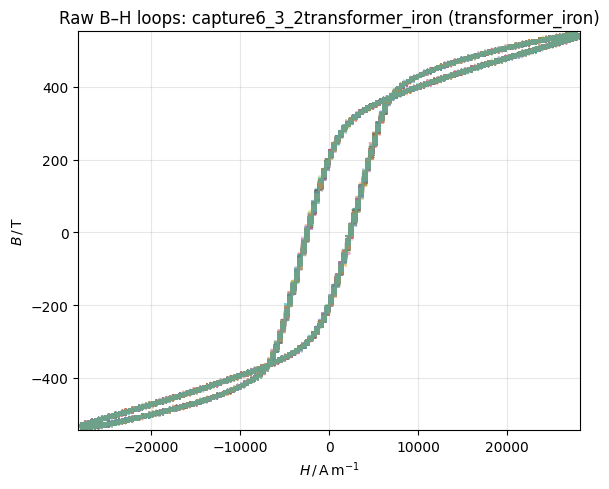

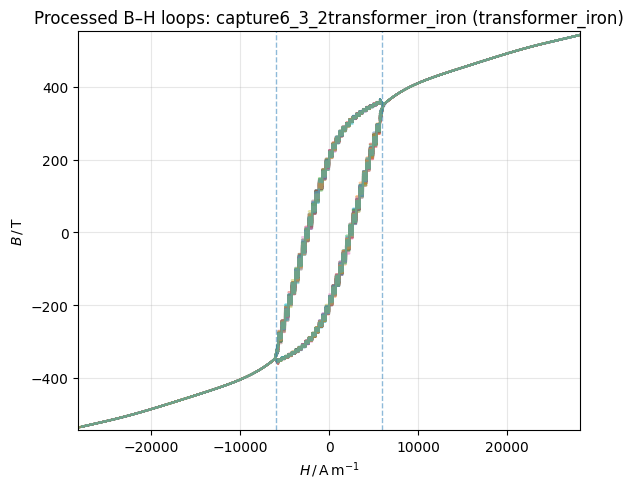

,quantity,N_loops_used,mean,std (loop-to-loop),SEM (std/√N)
0,B_range,20,1.077679e+03,0.951738,0.212815
1,H_range,20,5.612030e+04,169.830654,37.975289
2,loop_area,20,2.959910e+06,29876.463807,6680.580400
3,max_mu_r,20,1.037721e+05,5878.570598,1314.488347
4,min_mu_r,20,4.337512e+03,35.248458,7.881795
5,polyfit_grad_max,20,9.826412e-02,0.000272,0.000061
6,polyfit_grad_min,20,5.448739e-03,0.000044,0.000010
7,rms_B_residual,20,1.020007e+01,0.017874,0.003997



Headline results for this capture:
B_range = 1.08e+03 ± (standard error on mean) 0.21
H_range = 5.61e+04 ± (standard error on mean) 38
loop_area = 2.96e+06 ± (standard error on mean) 6.7e+03
max_mu_r = 1.04e+05 ± (standard error on mean) 1.3e+03
min_mu_r = 4.34e+03 ± (standard error on mean) 7.9
polyfit_grad_max = 0.0983 ± (standard error on mean) 6.1e-05
polyfit_grad_min = 0.00545 ± (standard error on mean) 9.9e-06
rms_B_residual = 10.2 ± (standard error on mean) 0.004


In [48]:
error_summary_ti, raw_ti, proc_ti = analyse_hysteresis_capture(
    material="transformer_iron",
    capture_key="capture6_3_2transformer_iron",
    lowerH=-6000.0,
    upperH=6000.0,
    plot_dir="plots/hysteresis",
)


/tmp/ipykernel_44463/1272145208.py:437: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_left = np.trapz(B_mid[left_mask], H_mid[left_mask])
/tmp/ipykernel_44463/1272145208.py:442: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_right = np.trapz(B_mid[right_mask], H_mid[right_mask])


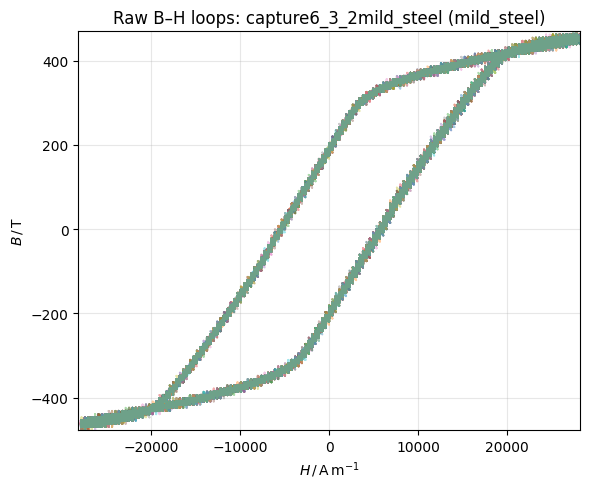

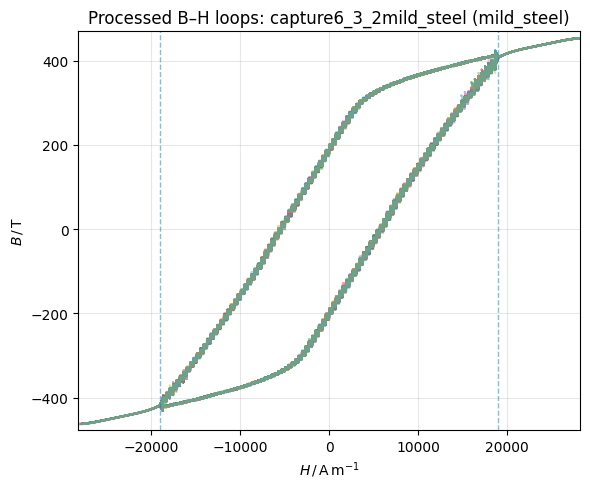

,quantity,N_loops_used,mean,std (loop-to-loop),SEM (std/√N)
0,B_range,20,9.147249e+02,0.474564,0.106116
1,H_range,20,5.608207e+04,140.045945,31.315225
2,loop_area,20,8.629647e+06,11427.854506,2555.345951
3,max_mu_r,20,3.851946e+04,6231.323413,1393.366274
4,min_mu_r,20,0.000000e+00,0.000000,0.000000
5,polyfit_grad_max,20,3.644364e-02,0.000031,0.000007
6,polyfit_grad_min,20,6.951836e-04,0.000336,0.000075
7,rms_B_residual,20,4.674953e+00,0.018416,0.004118



Headline results for this capture:
B_range = 915 ± (standard error on mean) 0.11
H_range = 5.61e+04 ± (standard error on mean) 31
loop_area = 8.63e+06 ± (standard error on mean) 2.6e+03
max_mu_r = 3.85e+04 ± (standard error on mean) 1.4e+03
min_mu_r = 0 ± (standard error on mean) 0
polyfit_grad_max = 0.0364 ± (standard error on mean) 7e-06
polyfit_grad_min = 0.000695 ± (standard error on mean) 7.5e-05
rms_B_residual = 4.67 ± (standard error on mean) 0.0041


In [49]:
error_summary_ti, raw_ti, proc_ti = analyse_hysteresis_capture(
    material="mild_steel",
    capture_key="capture6_3_2mild_steel",
    lowerH=-19000.0,
    upperH=19000.0,
    plot_dir="plots/hysteresis",
)
#min mu_r ~ 14


/tmp/ipykernel_44463/1272145208.py:437: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_left = np.trapz(B_mid[left_mask], H_mid[left_mask])
/tmp/ipykernel_44463/1272145208.py:442: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_right = np.trapz(B_mid[right_mask], H_mid[right_mask])


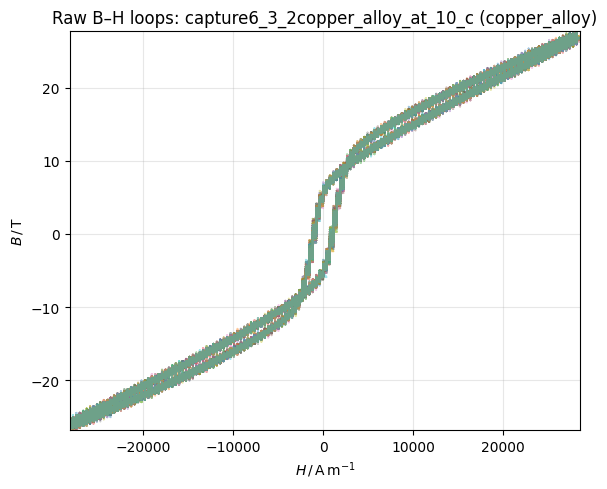

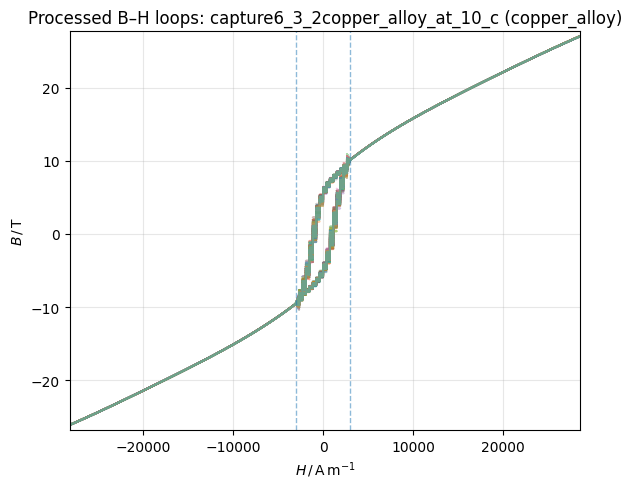

,quantity,N_loops_used,mean,std (loop-to-loop),SEM (std/√N)
0,B_range,20,53.098665,1.422432e-02,3.180654e-03
1,H_range,20,56787.823810,7.464975e-12,1.669219e-12
2,loop_area,20,28802.443287,5.702375e+02,1.275090e+02
3,max_mu_r,20,2464.066691,3.254976e+00,7.278347e-01
4,min_mu_r,20,421.481601,5.122197e+00,1.145358e+00
5,polyfit_grad_max,20,0.006861,7.901724e-05,1.766879e-05
6,polyfit_grad_min,20,0.000399,1.757183e-04,3.929181e-05
7,rms_B_residual,20,0.626211,1.781549e-03,3.983664e-04



Headline results for this capture:
B_range = 53.1 ± (standard error on mean) 0.0032
H_range = 5.68e+04 ± (standard error on mean) 1.7e-12
loop_area = 2.88e+04 ± (standard error on mean) 1.3e+02
max_mu_r = 2.46e+03 ± (standard error on mean) 0.73
min_mu_r = 421 ± (standard error on mean) 1.1
polyfit_grad_max = 0.00686 ± (standard error on mean) 1.8e-05
polyfit_grad_min = 0.000399 ± (standard error on mean) 3.9e-05
rms_B_residual = 0.626 ± (standard error on mean) 0.0004


In [50]:
error_summary_ti, raw_ti, proc_ti = analyse_hysteresis_capture(
    material="copper_alloy",
    capture_key="capture6_3_2copper_alloy_at_10_c",
    lowerH=-3000.0,
    upperH=3000.0,
    plot_dir="plots/hysteresis",
)